### Data Preperation and Logistic Regression implementation

In this notebook we will build a Logistic Regression to predict the loan approval of a given customer. We are using the preprocessed data that was saved to the disk in Exploratory Data Analysis stage. Below are the detailed steps of the model building for Logistic Regression.

1. Read the csv file and transform the data so that Logistic regression can be applied. The data transformations include converting categorical variables into numerical variables with the help of one hot encoding and manual encoding. Numerical variables are scaled using MinMaxScaler which would scale the whole feature into range of 0 to 1.

2. Split the data for training and validation. Train data would contain 70% of the records and test data would hold 30% of the records.

3. Build the model and verify the results on train and test data.

4. Finetune the hyper parameters and experiment with the threshold values of the classifier.

5. Feature selection

6. Final Model Evaluation

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,roc_curve,confusion_matrix,roc_auc_score,f1_score
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  
from sklearn.feature_selection import RFECV
scaler = MinMaxScaler()
import pickle

In [2]:
df = pd.read_csv('./Data/processed_file.csv')

In [3]:
df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Total_Income,Loan_Status,Ratio
0,LP001326,Male,No,0,Graduate,No,6782,0.0,130371.428571,360.0,1.0,Urban,6782.0,N,19.223154
1,LP001034,Male,No,1,Not Graduate,No,3596,0.0,100000.000000,240.0,0.0,Urban,3596.0,Y,27.808676
2,LP001052,Male,Yes,1,Graduate,No,3717,2925.0,151000.000000,360.0,1.0,Semiurban,6642.0,N,22.734116
3,LP001091,Male,Yes,1,Graduate,No,4166,3369.0,201000.000000,360.0,1.0,Urban,7535.0,N,26.675514
4,LP001123,Male,Yes,0,Graduate,No,2400,0.0,75000.000000,360.0,1.0,Urban,2400.0,Y,31.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71000.000000,360.0,1.0,Rural,2900.0,Y,24.482759
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40000.000000,180.0,1.0,Rural,4106.0,Y,9.741841
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253000.000000,360.0,1.0,Urban,8312.0,Y,30.437921
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187000.000000,360.0,1.0,Urban,7583.0,Y,24.660425


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             614 non-null    object 
 2   Married            614 non-null    object 
 3   Dependents         614 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      614 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    float64
 9   Loan_Amount_Term   614 non-null    float64
 10  Credit_History     614 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Total_Income       614 non-null    float64
 13  Loan_Status        614 non-null    object 
 14  Ratio              614 non-null    float64
dtypes: float64(6), int64(1), object(8)
memory usage: 72.1+ KB


In [5]:
def process_data_for_logreg(df):
    '''
    Preprocessing steps to implement Logistic Regression
    
    Input :
        DataFrame to be transformed.
    
    Return :
        Transformed DataFrame
    '''
    
    df['Gender'] = df['Gender'].replace({'Male':1,'Female':0})
    df['Married'] = df['Married'].replace({'No':0,'Yes':1})
    df['Education'] = df['Education'].replace({'Graduate':1,'Not Graduate':0})
    df['Self_Employed'] = df['Self_Employed'].replace({'Yes':1,'No':0})
    df['Loan_Status'] = df['Loan_Status'].replace({'Y':1,'N':0})
    x = pd.get_dummies(df['Dependents'],prefix = 'Dep',drop_first = True)
    y = pd.get_dummies(df['Property_Area'],prefix = 'PA',drop_first = True)
    df[['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','Total_Income','Ratio']] = scaler.fit_transform(df[['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','Total_Income','Ratio']])
    df = df.drop(columns = ['Loan_ID','Dependents','Property_Area'])
    df = pd.concat([df,x,y],axis = 1) 
    
    return df[['Gender', 'Married', 'Education', 'Self_Employed', 'ApplicantIncome',
       'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History',
       'Total_Income', 'Dep_1', 'Dep_2', 'Dep_3+',
       'PA_Semiurban', 'PA_Urban', 'Ratio','Loan_Status']]

In [6]:
df = process_data_for_logreg(df)
df

,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Total_Income,Dep_1,Dep_2,Dep_3+,PA_Semiurban,PA_Urban,Ratio,Loan_Status
0,1,0,1,0,0.082028,0.000000,0.175646,0.743590,1.0,0.067121,0,0,0,0,1,0.088486,0
1,1,0,0,0,0.042622,0.000000,0.131693,0.487179,0.0,0.027075,1,0,0,0,1,0.133976,1
2,1,1,1,0,0.044119,0.070199,0.205499,0.743590,1.0,0.065361,1,0,0,1,0,0.107088,0
3,1,1,1,0,0.049672,0.080855,0.277858,0.743590,1.0,0.076586,1,0,0,0,1,0.127972,0
4,1,1,1,0,0.027829,0.000000,0.095514,0.743590,1.0,0.012042,0,0,0,0,1,0.152209,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,0,0,1,0,0.034014,0.000000,0.089725,0.743590,1.0,0.018326,0,0,0,0,0,0.116353,1
610,1,1,1,0,0.048930,0.000000,0.044863,0.358974,1.0,0.033485,0,0,1,0,0,0.038249,1
611,1,1,1,0,0.097984,0.005760,0.353111,0.743590,1.0,0.086352,1,0,0,0,1,0.147907,1
612,1,1,1,0,0.091936,0.000000,0.257598,0.743590,1.0,0.077189,0,1,0,0,1,0.117295,1


In [7]:
corr = df.iloc[:,0:16].corr()
corr

,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Total_Income,Dep_1,Dep_2,Dep_3+,PA_Semiurban,PA_Urban,Ratio
Gender,1.000000,0.364569,-0.045364,-0.000525,0.058809,0.082912,0.101768,-0.074030,0.004466,0.093191,-0.004466,0.129953,0.096319,-0.108623,0.034530,-0.114684
Married,0.364569,1.000000,-0.012304,0.004489,0.051708,0.075948,0.145106,-0.100912,-0.003534,0.083319,0.113853,0.249547,0.132566,0.005845,0.000546,-0.028159
Education,-0.045364,-0.012304,1.000000,0.010383,0.140760,0.062290,0.156238,0.073928,0.177337,0.161362,0.013355,-0.020822,-0.055288,0.039410,0.034279,-0.099613
Self_Employed,-0.000525,0.004489,0.010383,1.000000,0.127180,-0.016100,0.113809,-0.033739,-0.004861,0.113000,0.082044,0.032434,0.003278,0.008710,-0.030338,-0.061342
ApplicantIncome,0.058809,0.051708,0.140760,0.127180,1.000000,-0.116605,0.559821,-0.046531,-0.003993,0.893037,0.040861,-0.034650,0.156687,-0.014246,-0.000598,-0.265075
CoapplicantIncome,0.082912,0.075948,0.062290,-0.016100,-0.116605,1.000000,0.184822,-0.059383,0.016565,0.342781,-0.029769,0.010016,0.041491,-0.027044,0.022776,-0.171575
LoanAmount,0.101768,0.145106,0.156238,0.113809,0.559821,0.184822,1.000000,0.036698,0.000421,0.613254,0.059406,0.021368,0.167181,-0.013895,-0.028217,0.185261
Loan_Amount_Term,-0.074030,-0.100912,0.073928,-0.033739,-0.046531,-0.059383,0.036698,1.000000,-0.007758,-0.070917,-0.088492,-0.010609,-0.077273,0.059141,-0.094279,0.134160
Credit_History,0.004466,-0.003534,0.177337,-0.004861,-0.003993,0.016565,0.000421,-0.007758,1.000000,0.003728,-0.012408,-0.002614,-0.071791,0.024409,-0.004126,-0.074753
Total_Income,0.093191,0.083319,0.161362,0.113000,0.893037,0.342781,0.613254,-0.070917,0.003728,1.000000,0.025162,-0.028237,0.167003,-0.025728,0.009754,-0.328462


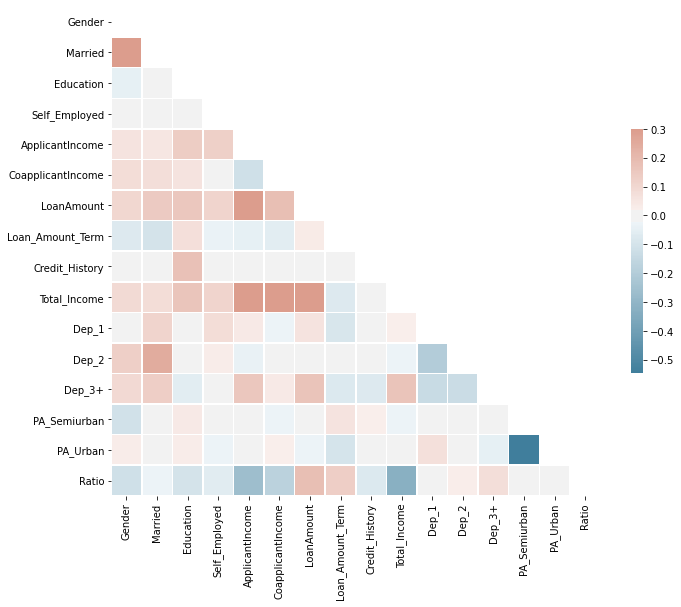

In [8]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap 
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Continuous Features like TotalIncome, ApplicantIncome,Coapplicant Income and LoanAmount show positive strong correlation. Hence TotalIncome is retained in the model and the remaining are dropped because of multicollinearity.

In [9]:
df.drop(['ApplicantIncome','CoapplicantIncome','LoanAmount'],axis = 1,inplace = True)

In [10]:
df

,Gender,Married,Education,Self_Employed,Loan_Amount_Term,Credit_History,Total_Income,Dep_1,Dep_2,Dep_3+,PA_Semiurban,PA_Urban,Ratio,Loan_Status
0,1,0,1,0,0.743590,1.0,0.067121,0,0,0,0,1,0.088486,0
1,1,0,0,0,0.487179,0.0,0.027075,1,0,0,0,1,0.133976,1
2,1,1,1,0,0.743590,1.0,0.065361,1,0,0,1,0,0.107088,0
3,1,1,1,0,0.743590,1.0,0.076586,1,0,0,0,1,0.127972,0
4,1,1,1,0,0.743590,1.0,0.012042,0,0,0,0,1,0.152209,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,0,0,1,0,0.743590,1.0,0.018326,0,0,0,0,0,0.116353,1
610,1,1,1,0,0.358974,1.0,0.033485,0,0,1,0,0,0.038249,1
611,1,1,1,0,0.743590,1.0,0.086352,1,0,0,0,1,0.147907,1
612,1,1,1,0,0.743590,1.0,0.077189,0,1,0,0,1,0.117295,1


In [11]:
X,y = df.iloc[:,0:13],df.iloc[:,-1]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 41)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

logreg = LogisticRegression(random_state = 2020)
logreg.fit(X_train,y_train)

train_pred = logreg.predict(X_train)
print('Train Results :\n')
print('Confusion Matrix \n',confusion_matrix(y_train,train_pred))
print('Train Accuracy : ',logreg.score(X_train,y_train))
print('Area under the curve : ',roc_auc_score(y_train,train_pred))
print('f1 score : ',f1_score(y_train,train_pred))


val_pred = logreg.predict(X_test)
print('\nValidation Results :')
print('Confusion Matrix \n',confusion_matrix(y_test,val_pred))
print('validation Accuracy : ',logreg.score(X_test,y_test))
print('Area under the curve : ',roc_auc_score(y_test,val_pred))
print('f1 score : ',f1_score(y_test,val_pred))

(429, 13) (185, 13) (429,) (185,)
Train Results :

Confusion Matrix 
 [[ 60  78]
 [ 13 278]]
Train Accuracy :  0.7878787878787878
Area under the curve :  0.695054534588376
f1 score :  0.8593508500772797

Validation Results :
Confusion Matrix 
 [[ 25  29]
 [  4 127]]
validation Accuracy :  0.8216216216216217
Area under the curve :  0.7162143059089623
f1 score :  0.8850174216027874


Let us check the feature Importance of the whole model.

Coefficients of the classifier [ 0.08819521  0.53813987 -0.17468874  0.08043311 -0.86533542  2.6295615
 -0.54889617 -0.29541376  0.46386497  0.29192059  0.58753616  0.22190487
 -0.54896125]


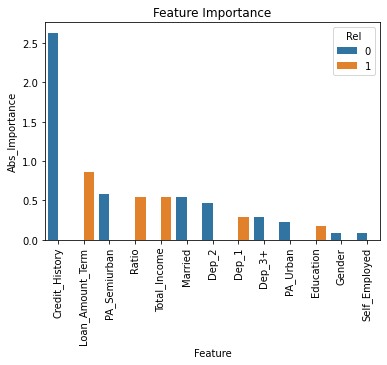

In [12]:
def plot_feat_imp(df,clf):
    '''
    Plots feature importance of a classifier for a given dataframe
    
    Input Parameters :
        df : Input dataframe
        clf : Classifier
    
    Returns :
        A plot object
        
    '''
    print('Coefficients of the classifier', clf.coef_[0])
    feat_imp = pd.DataFrame(list(zip(df.columns,clf.coef_[0])),columns = ['Feature','Coefficient'])
    feat_imp['Abs_Importance'] = feat_imp['Coefficient'].apply(lambda x : -x if x < 0 else x)
    feat_imp['Rel'] = feat_imp['Coefficient'].apply(lambda x : 1 if x < 0 else 0)
    feat_imp = feat_imp.sort_values(by = 'Abs_Importance',ascending = False)
    
    g = sns.barplot(x = 'Feature', y = 'Abs_Importance',hue = 'Rel',data = feat_imp)
    g.set_title('Feature Importance')
    z = g.set_xticklabels(g.get_xticklabels(),rotation=90)
    
    return z

k = plot_feat_imp(df,logreg)

### Aim of the application in terms of Business

<img src="./Screenshots/Strategy.jpg">

### Selection of Metrics for the problem Statement

<img src="./Screenshots/Confusion_Matrix.jpg">

Metrics chosen for a problem statement should be aligned with the Business goals. In the Finance Industry which is a regulated industry, particularly lending, all the metrics are monitered, but the goal of the application is to minimise the risk involved and also serve to the rightful customers. In such cases f1_score is one of the favoured metric. 

f1_score is a metric defined as the harmonic mean of precision and recall. The ability to balance both Faslse Positive and False Negatives makes f1_score an apt metric for the problem statement. As the start up flourishes this strategy will be void, then the go to  metrics for the loan approval would be f1 beta score, beta value should be aligned with the new strategy.

The above model looks to be working fine on validation set. Train accuracy and validation f1 score are high and validation f1 score exceeds the train f1 score by a good margin. This suggests that the model is good enough. But let us explore if we can push the limits by using GridSearchCV.

In [13]:
params = {
    'C' : [0.75,1,1.25,1.5],
    'solver' : ['lbfgs','sag','saga'],
    'max_iter' : [150,200,250]
}
grid = GridSearchCV(estimator=logreg, param_grid=params,cv = 3, scoring = 'f1',n_jobs = -1)
grid.fit(X_train,y_train)
grid.best_estimator_,grid.best_score_

(LogisticRegression(C=0.75, max_iter=150, random_state=2020),
 0.8596102414147326)

In [14]:
grid_pred = grid.best_estimator_.predict(X_test)
print('f1 score of grid search on validation data: ',f1_score(y_test,grid_pred))

f1 score of grid search on validation data:  0.8850174216027874


The gridsearch results do not yield better results than the default settings of the LogisticRegression. So we will stick to the basic version of LogisticRegression classifier.

decision_function() and predict_proba() methods are helpful in understanding the confidence of the predictions made by the model. decison_function returns a value for each record. The distance from the value to zero is the strength of the prediction. On the other side predict_proba() predicts the probability of the each class of the classifier. The metrics of a classifier can be enhanced using the decision function values by either increasing the threshold or reducing the threshold.

In [15]:
logreg.decision_function(X_test)

array([ 1.41462154,  1.25682837,  2.12209576,  1.84989244, -0.7510025 ,
        0.92141859, -1.34863712,  1.03326657,  2.41368129, -2.16928885,
        1.18214539,  1.53992546,  1.2611045 ,  2.12941817, -0.49173061,
        1.66209303,  0.69141092, -1.24739666,  1.32228203,  1.09429771,
       -1.69865436,  1.31557743,  1.97980165,  1.68758953,  1.36081528,
        2.21676978,  2.2850839 ,  1.55914845,  0.47625332,  1.53590422,
        1.72353212,  2.16516005, -0.77362543,  1.06380981,  0.76563561,
        1.12760035,  1.06876827,  1.25950941,  1.1925085 ,  1.84477332,
        1.06429386,  0.24672267, -1.19907471,  0.55210047,  1.37031558,
        1.62395215,  0.70219943,  0.99765599,  2.22590454,  2.13850791,
        1.6798177 ,  1.65505707,  0.92268955,  1.04833583,  1.13769239,
       -1.14444086,  1.81817741,  1.19089284,  1.65259816, -0.42889615,
        1.02212545, -2.07270136,  1.24720368,  0.5587309 ,  2.15371182,
        1.79511851,  1.96933581,  2.1204464 ,  1.67946373,  1.02

In [16]:
final_prediction = logreg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, final_prediction)
thresholds
#logreg.predict_proba(X_test)

array([1.91786464, 0.91786464, 0.89175394, 0.88791803, 0.86351226,
       0.85755368, 0.85461872, 0.8544859 , 0.8504865 , 0.84989857,
       0.84288039, 0.84283351, 0.83782508, 0.83565752, 0.82378461,
       0.82345389, 0.82286853, 0.81952183, 0.78533596, 0.78516287,
       0.77849382, 0.77847965, 0.77256642, 0.76718941, 0.75539578,
       0.75147932, 0.74919014, 0.7467829 , 0.74351025, 0.74341793,
       0.74105521, 0.7404552 , 0.73644006, 0.73617335, 0.73341191,
       0.73059747, 0.7155898 , 0.71533107, 0.70340062, 0.70178107,
       0.69450524, 0.68954224, 0.68687316, 0.68527421, 0.68425955,
       0.68257603, 0.66628072, 0.6425679 , 0.64062324, 0.63635238,
       0.63422916, 0.633928  , 0.61410847, 0.59164063, 0.54171113,
       0.31569537, 0.29717212, 0.29338364, 0.26247763, 0.17798525,
       0.17077228, 0.10254246])

In [17]:
def vary_threholds(thresholds):
    '''
    Function to create a dataframe with f1_score,accuracy and area under roc for varying thresholds.
    
    Parameters:
        thresholds : Threholds generated by the roc_curve fuction
        
    Returns :
        scores : a dataframe with f1_score,accuracy and area under roc for varying thresholds.
        
    '''
    f1_score_ls = []
    accuracy_ls = []
    roc_ls = []
    for thres in thresholds:
        y_pred = np.where(final_prediction>thres,1,0)
        f1_score_ls.append(f1_score(y_test, y_pred))
        accuracy_ls.append(accuracy_score(y_test, y_pred, normalize=True))
        roc_ls.append(roc_auc_score(y_test, y_pred))

    scores = pd.concat([pd.Series(thresholds), pd.Series(f1_score_ls),pd.Series(accuracy_ls),pd.Series(roc_ls)],axis=1)
    scores.columns = ['thresholds', 'f1_score','accuracy','area_roc']
    scores.sort_values(by='f1_score', ascending=False, inplace=True)
    return scores.head()

z = vary_threholds(thresholds)
z

,thresholds,f1_score,accuracy,area_roc
54,0.541711,0.881119,0.816216,0.712398
53,0.591641,0.880282,0.816216,0.717840
52,0.614108,0.876325,0.810811,0.714023
51,0.633928,0.871429,0.805405,0.715649
50,0.634229,0.867384,0.800000,0.711832


Logistic Regression works based on logloss function. Logistic regression predicts the probability of a record for each class, and by default assumes that the threshold is 0.5. If the probability of a class is greater than 0.5, then the class is given as the output. But the threshold of 0.5 can be varied based on applications and Changing the threshold of the classifier here yields very minimal change in the metrics, so we proceed with the LogisticRegression with default settings as our model.

### Need for Feature Selection

Usually when a dataset has huge number of features and records, training the data would consume a lot of computation power and time. Once the model is deployed into the production environment and after few days if the model becomes ineffective due to unseen data, the model needs to be retrained and to make things quicker retraining the whole data on a few set of variables would take less amount of time. So feature selection techniques can help select features that are significant and add value to the model.

From the above list of the features and coefficients, we have to select few important features, that are sufficient to predict the outcome without any compromise on the metrics. To select few features from the whole list of features we use the recursive feature elimination with cross validation technique. 

In [18]:
rfecv = RFECV(estimator = logreg, step=1, cv=StratifiedKFold(3),scoring='roc_auc')
rfecv.fit(X_train,y_train)
print("Optimal number of features : ", rfecv.n_features_)

Optimal number of features :  7


In [19]:
z = list(zip(rfecv.ranking_,df.columns))
z.sort(key = lambda x:x[0])
pd.DataFrame(z,columns = ['Rank','Feature'])

,Rank,Feature
0,1,Married
1,1,Loan_Amount_Term
2,1,Credit_History
3,1,Total_Income
4,1,Dep_2
5,1,PA_Semiurban
6,1,Ratio
7,2,Dep_1
8,3,Dep_3+
9,4,PA_Urban


From the above results we have gained the ranking of the features. We implement the six significant features into our model.

### Rebuilding the model with selected features

In [20]:
df1 = df[['Married','Loan_Amount_Term','Credit_History','Total_Income','Dep_2','PA_Semiurban','Ratio','Loan_Status']]

X,y = df1.iloc[:,0:7],df1.iloc[:,-1]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 41)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

logreg = LogisticRegression(random_state = 2020)
logreg.fit(X_train,y_train)

train_pred = logreg.predict(X_train)
print('Train Results :\n')
print('Confusion Matrix \n',confusion_matrix(y_train,train_pred))
print('Train Accuracy : ',logreg.score(X_train,y_train))
print('Area under the curve : ',roc_auc_score(y_train,train_pred))
print('f1 score : ',f1_score(y_train,train_pred))


val_pred = logreg.predict(X_test)
print('\nValidation Results :')
print('Confusion Matrix \n',confusion_matrix(y_test,val_pred))
print('validation Accuracy : ',logreg.score(X_test,y_test))
print('Area under the curve : ',roc_auc_score(y_test,val_pred))
print('f1 score : ',f1_score(y_test,val_pred))

(429, 7) (185, 7) (429,) (185,)
Train Results :

Confusion Matrix 
 [[ 60  78]
 [ 13 278]]
Train Accuracy :  0.7878787878787878
Area under the curve :  0.695054534588376
f1 score :  0.8593508500772797

Validation Results :
Confusion Matrix 
 [[ 25  29]
 [  4 127]]
validation Accuracy :  0.8216216216216217
Area under the curve :  0.7162143059089623
f1 score :  0.8850174216027874


Coefficients of the classifier [ 0.54372815 -0.8844264   2.59874753 -0.5234926   0.50859978  0.46445255
 -0.53089391]


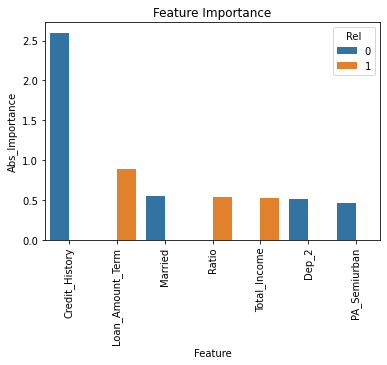

In [21]:
k = plot_feat_imp(df1,logreg)

In [22]:
pickle.dump(logreg, open('./Models/Logistic_Regression.sav', 'wb'))
pickle.dump(scaler,open('./Models/scaler.sav','wb'))

### Conclusion

From the above model, we can conclude that the following predictors have greater ability to predict the outcome of the loan application. Feature represented in blue color reflects direct relation with the outcome and orange color reflects inverse relation with the outcome.

1. Credit_History : If the candidate has the credit History the chances of a succesful outcome is as high as 2.6 times compared to a candate without credit history.
2. Loan Amount Term : Loan amount term is inversely related to the outcome of the application. Applications with lower term have greater edge of successful loan approval.
3. Married : Candidate who is married has greater probability of a successful loan.
4. Ratio : Ratio of the Loan Amount to Total Income is inversely related to the approval of a Loan. Candidates with lower ratio have higher chances of a loan approval.
5. Total_Income : Total_Income is inversely related to approval of a Loan. Candidates with low total income have higher chances of loan approval.
6. Dep_2 : Candidates with two dependents have higher chances of approval.
7. PA-SemiUrban : Candidates from SemiUrban region have higher likelihood of approval of loans.
